<a href="https://colab.research.google.com/github/slunara/car_damage_detector/blob/main/models/EfficientNetV2S_car_damage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car damage classifier

EfficientNetV2S pre trained model is used to classify where the image contain the damaged car or not.

In [1]:
#import necessary librabry
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Download data

Two datasets are used

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anujms/car-damage-detection")

print("Path to dataset files:", path)

100%|██████████| 123M/123M [00:02<00:00, 58.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1


In [3]:
import os

# Define the dataset path
dataset_path = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"

# List files and folders
os.listdir(dataset_path)

['validation', 'training']

In [4]:
#defining the base, train and validation directory path
base_dir = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
#defining the damage and whole , train and validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

## Preprocess the data

Data Augmentation is used to:
1. Rescale the data
2. to bring all the image to same dimension  i.e. 150x150


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Fine tune EfficientNetV2S

For training 1840 images are used.
For Validation 460 image are used.

Training and evaluating the model with binary crossentropy loss, accuracy, precision , recall

In [8]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetV2S  # EfficientNetV2 Small
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

# Load EfficientNetV2 base model (without top layers)
base_model = EfficientNetV2S(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

# Freeze the base model layers to prevent training in the first few epochs
base_model.trainable = False  # Set to True if fine-tuning later

# Add custom layers on top of EfficientNetV2
x = GlobalAveragePooling2D()(base_model.output)  # Better than Flatten for EfficientNet
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)  # Helps prevent overfitting
x = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define final model
model = Model(base_model.input, x)

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=["accuracy", "Precision", "Recall"])

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=2)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 - 73s - 797ms/step - Precision: 0.5641 - Recall: 0.6120 - accuracy: 0.5696 - loss: 0.6770 - val_Precision: 0.6821 - val_Recall: 0.5783 - val_accuracy: 0.6543 - val_loss: 0.6549
Epoch 2/30
92/92 - 6s - 64ms/step - Precision: 0.6094 - Recall: 0.6598 - accuracy: 0.6185 - loss: 0.6558 - val_Precision: 0.6367 - val_Recall: 0.7087 - val_accuracy: 0.6522 - val_loss: 0.6350
Epoch 3/30
92/92 - 10s - 109ms/step - Precision: 0.6418 - Recall: 0.6815 - accuracy: 0.6505 - loss: 0.6385 - val_Precision: 0.7426 - val_Recall: 0.4391 - val_accuracy: 0.6435 - val_loss: 0.6306
Epoch 4/30
92/92 - 6s - 69ms/step - Precision: 0.6400 - Recall: 0.6783 - accuracy: 0.6484 - loss: 0.6289 - val_Precision: 0.7517 - val_Recall: 0.4739 - val_accuracy: 0.6587 - val_loss: 0.6215
Epoch 5/30
92/92 - 10s - 111ms/step - Precision: 0.6285 - Recall: 0.6565 - accuracy: 0.6342 - loss: 0.6289 - val_Precision: 0.6892 - val_Recall: 0.6652 - val_accuracy: 0.6826 - val_loss: 0.6091
Epoch 6/30
92/92 - 6s - 63ms/step - Precision

In [9]:
#weights saving
model.save("classifier.keras")

## Results

plotting the history of train and validation loss, accurcy, precision, recall

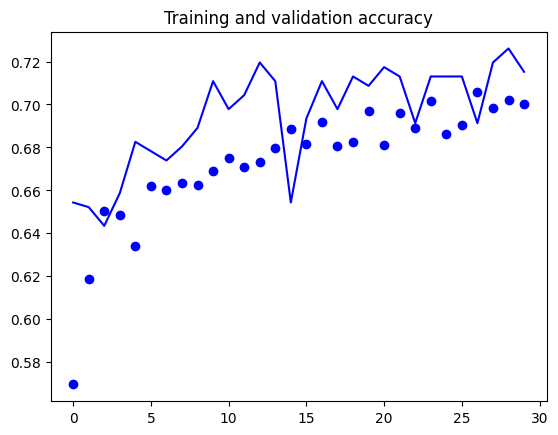

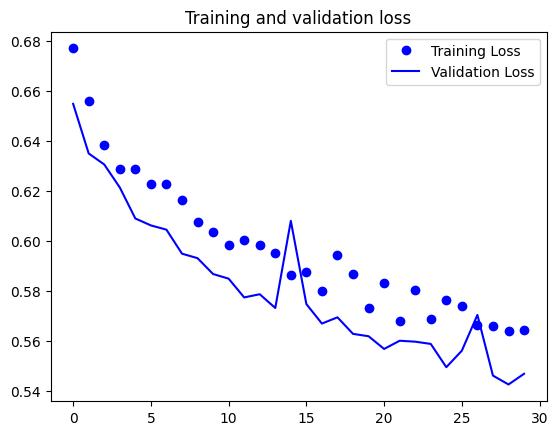

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

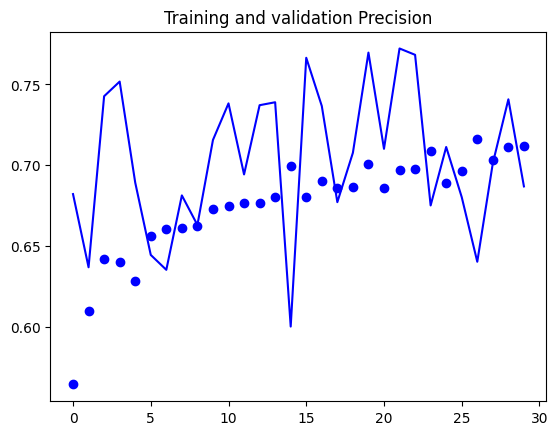

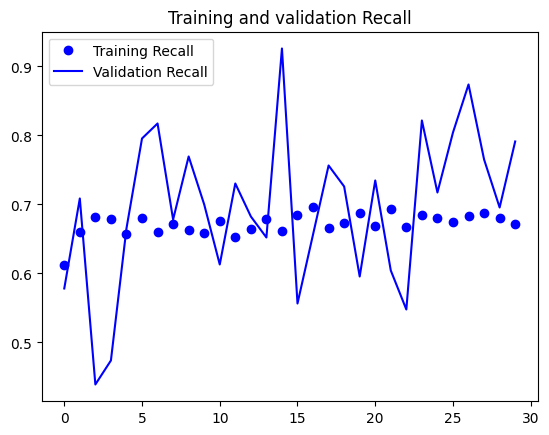

In [11]:
import matplotlib.pyplot as plt
acc = history.history['Precision']
val_acc = history.history['val_Precision']
loss = history.history['Recall']
val_loss = history.history['val_Recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Precision')
plt.plot(epochs, val_acc, 'b', label='Validation Precision')
plt.title('Training and validation Precision')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Recall')
plt.plot(epochs, val_loss, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

Testing

In [20]:
train_generator.class_indices

{'00-damage': 0, '01-whole': 1}

In [23]:
validation_generator.class_indices

{'00-damage': 0, '01-whole': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
The car is damaged


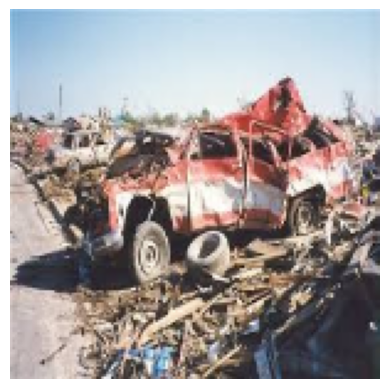

In [28]:
import cv2
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/00-damage/0006.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.6881686]]
The car is not damaged


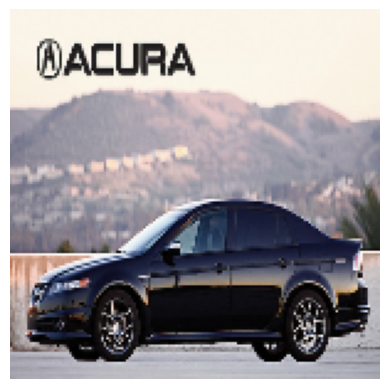

In [13]:
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/01-whole/0006.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)


Conclusion: Successfully build a classifier to classify the images containing into damage and undamage cars.

# Inference - SURA data

In [14]:
# Clone the GitHub repo
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/test_data"

assert os.path.exists(test_data_dir), "Test data folder not found!"
print("Test data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 427 (delta 37), reused 15 (delta 6), pack-reused 259 (from 3)
Receiving objects: 100% (427/427), 138.69 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (250/250), done.
Test data downloaded successfully!


In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Define image size
IMG_SIZE = (150, 150)

# Define class labels (damage = 0, whole = 1)
class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.vstack(test_images), np.array(test_labels), test_filenames

# Load test images
X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"✅ Loaded {len(X_test)} test images!")

✅ Loaded 152 test images!


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming y_test and y_pred_labels are already defined
# y_test: True labels (flattened if needed)
# y_pred_labels: Predicted labels

# ✅ Calculate Accuracy
accuracy = accuracy_score(y_test.flatten(), y_pred_labels)

# ✅ Calculate Precision for Class 0 (Damaged Cars)
precision_damage = precision_score(y_test.flatten(), y_pred_labels, pos_label=0)

# ✅ Calculate Recall for Class 0 (Damaged Cars)
recall_damage = recall_score(y_test.flatten(), y_pred_labels, pos_label=0)

# ✅ Print the results
print(f"Model Performance Metrics:")
print(f"Accuracy: {accuracy* 100:.2f}%")
print(f"Precision for Damaged Cars (Class 0): {precision_damage* 100:.2f}%")
print(f"Recall for Damaged Cars (Class 0): {recall_damage* 100:.2f}%")


Model Performance Metrics:
Accuracy: 78.95%
Precision for Damaged Cars (Class 0): 13.04%
Recall for Damaged Cars (Class 0): 20.00%


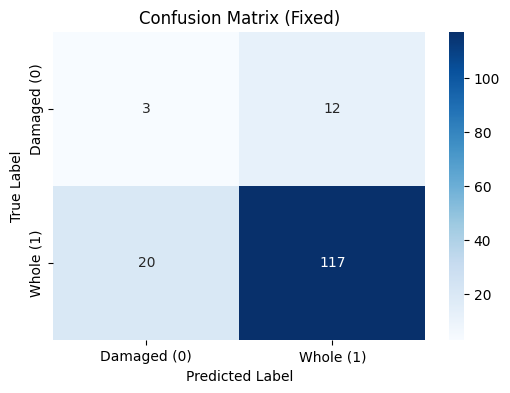

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred_labels = y_pred_labels.flatten()

cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Damaged (0)", "Whole (1)"],
            yticklabels=["Damaged (0)", "Whole (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fixed)")
plt.show()

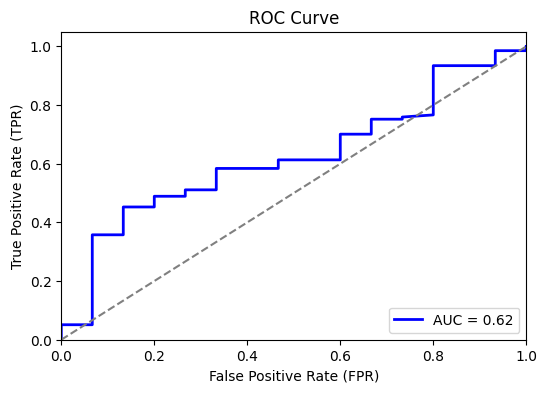

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Use probabilities
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Define image size
IMG_SIZE = (150, 150)

# Define class labels (damage = 0, whole = 1)
class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []
    test_filepaths = []  # Store full paths for loading images later

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)
            test_filepaths.append(img_path)  # Store full path

    return np.vstack(test_images), np.array(test_labels), test_filenames, test_filepaths

# Load test images
X_test, y_test, filenames, filepaths = load_test_images(test_data_dir)

print(f"✅ Loaded {len(X_test)} test images!")



✅ Loaded 152 test images!


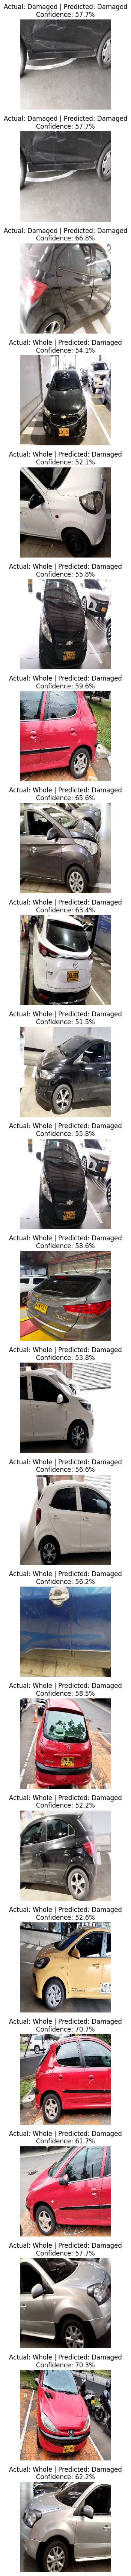

In [52]:
# 🔍 Filter images where predicted probability is below 0.2
low_confidence_indices = np.where(y_pred < 0.5)[0]  # Get indices of low-confidence predictions
low_confidence_images = [filepaths[i] for i in low_confidence_indices]
low_confidence_actual = [y_test[i] for i in low_confidence_indices]
low_confidence_pred = [y_pred_labels[i] for i in low_confidence_indices]
low_confidence_probs = [y_pred[i] for i in low_confidence_indices]

# ✅ Check if there are any low-confidence images before creating subplots
if len(low_confidence_images) > 0:
    # ✅ Display the images with their actual & corrected predicted confidence
    fig, axes = plt.subplots(nrows=len(low_confidence_images), figsize=(8, len(low_confidence_images) * 3))

    for i, img_path in enumerate(low_confidence_images):
        img = load_img(img_path, target_size=(300, 300))  # Load with larger size
        axes[i].imshow(img)
        axes[i].axis("off")

        # Determine actual and predicted labels
        actual_label = "Damaged" if low_confidence_actual[i] == 0 else "Whole"
        predicted_label = "Damaged" if low_confidence_pred[i] == 0 else "Whole"

        # ✅ Correct confidence calculation
        if low_confidence_pred[i] == 1:  # If predicted "Whole"
            probability = low_confidence_probs[i][0] * 100  # Confidence in class 1 # Extract the value from the array
        else:  # If predicted "Damaged"
            probability = (1 - low_confidence_probs[i][0]) * 100  # Confidence in class 0 # Extract the value from the array

        # ✅ Set title with corrected confidence
        axes[i].set_title(f"Actual: {actual_label} | Predicted: {predicted_label}\nConfidence: {probability:.1f}%")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No low-confidence images found.") # Print a message if no low-confidence images are found.